In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('house_prices_with_missing.csv')

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
#fonction d'affichage des valeurs manquantes

def Affichage_graphe(imputation,methode) :

    print(f"Resumé des valeurs manquantes par {methode}")
    print(imputation.isnull().sum())

    #heatmap des valeurs manaquantes 
    plt.figure(figsize=(10,5))
    sns.heatmap(imputation.isnull(), cbar=False, cmap="viridis")
    plt.title(f"Valeurs manquantes par variables apres {methode} ")
    plt.show()

In [32]:
df.head()

,surface_m2,n_chambres,n_sdb,annee_construction,quartier,prix_vente
0,114.901425,1.0,1.0,1971.0,D,224113.48
1,95.852071,1.0,4.0,2003.0,D,192102.28
2,119.430656,1.0,1.0,1955.0,D,222503.53
3,NaN,4.0,3.0,1999.0,E,301411.15
4,92.975399,4.0,2.0,1970.0,A,301053.92


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   surface_m2          9500 non-null   float64
 1   n_chambres          9700 non-null   float64
 2   n_sdb               9800 non-null   float64
 3   annee_construction  9600 non-null   float64
 4   quartier            9900 non-null   object 
 5   prix_vente          10000 non-null  float64
dtypes: float64(5), object(1)
memory usage: 468.9+ KB


In [34]:
print("Resumé des valeurs manquantes.")
print(df.isnull().sum())

Resumé des valeurs manquantes.
surface_m2            500
n_chambres            300
n_sdb                 200
annee_construction    400
quartier              100
prix_vente              0
dtype: int64


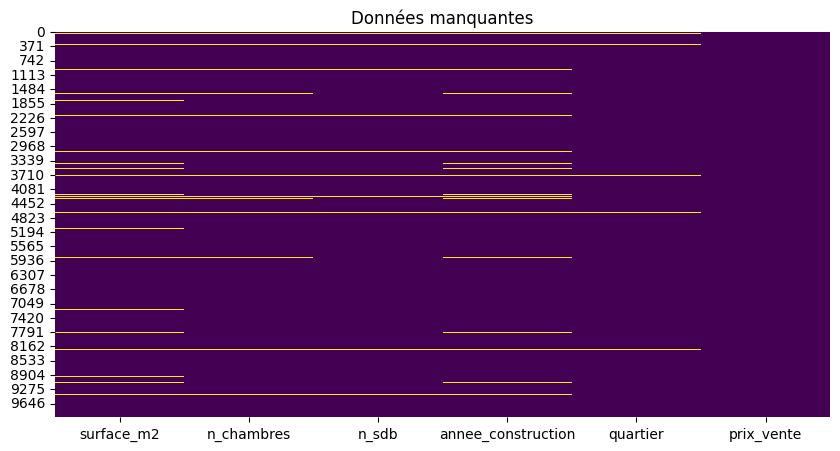

In [35]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False , cmap="viridis")
plt.title("Données manquantes")
plt.show()

In [36]:
from sklearn.impute import SimpleImputer

#colonnes numeriques et catégorielles

num_cols = ['surface_m2', 'n_chambres', 'n_sdb', 'annee_construction']
cat_cols = ['quartier']

#Imputations 
imputer_mean = SimpleImputer(strategy='mean')
imputer_median = SimpleImputer(strategy='median')
imputer_mode = SimpleImputer(strategy='most_frequent')

#Exemple d'imputation la médiane (quantitative ) + mode ( qualitatif)

df_1 = df.copy()
df_1[num_cols] = imputer_median.fit_transform(df_1[num_cols])
df_1[cat_cols] = imputer_mode.fit_transform(df_1[cat_cols])


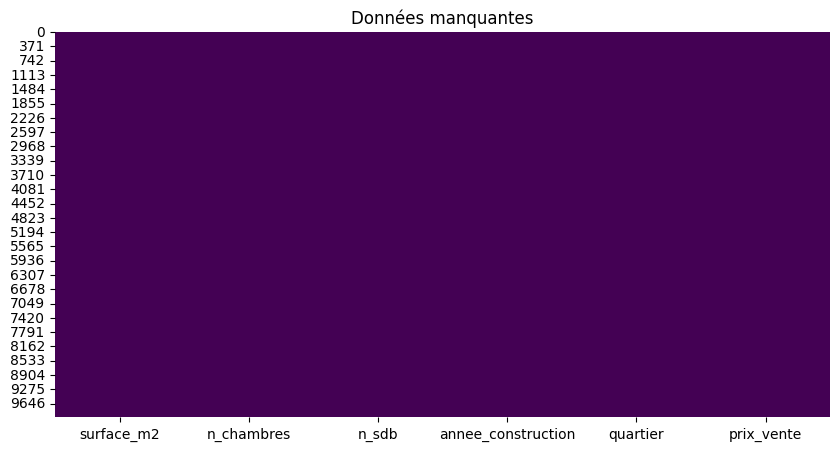

In [37]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.heatmap(df_1.isnull(), cbar=False , cmap="viridis")
plt.title("Données manquantes")
plt.show()

In [38]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   surface_m2          10000 non-null  float64
 1   n_chambres          10000 non-null  float64
 2   n_sdb               10000 non-null  float64
 3   annee_construction  10000 non-null  float64
 4   quartier            10000 non-null  object 
 5   prix_vente          10000 non-null  float64
dtypes: float64(5), object(1)
memory usage: 468.9+ KB


# une autre methode avec la biblioteque pandas 

In [ ]:
df_2 = df.copy()

# Imputation médiane pour les colonnes numériques
for col in num_cols:
    median_value = df_2[col].median()
    df_2[col].fillna(median_value, inplace=True)

# Imputation du mode pour les colonnes catégorielles
for col in cat_cols:
    mode_value = df_2[col].mode()[0]
    df_2[col].fillna(mode_value, inplace=True)


Resumé des valeurs manquantes
surface_m2            0
n_chambres            0
n_sdb                 0
annee_construction    0
quartier              0
prix_vente            0
dtype: int64


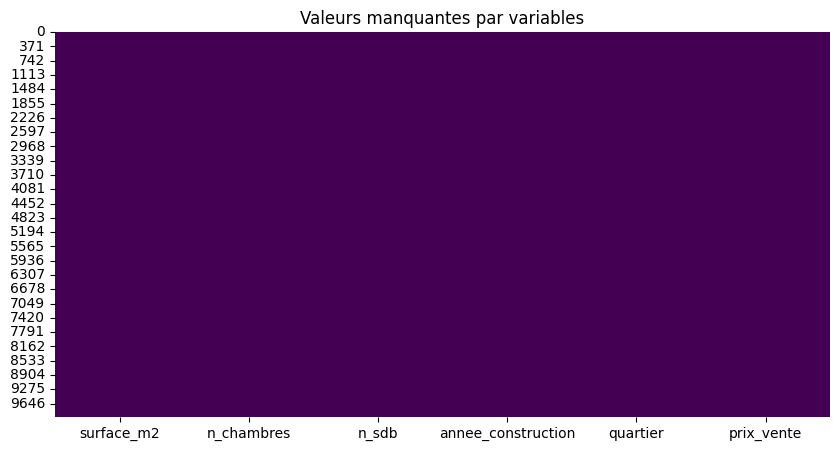

In [42]:
#Affichage des valeurs manquantes

print("Resumé des valeurs manquantes")
print(df_2.isnull().sum())

#heatmap des valeurs manaquantes 
plt.figure(figsize=(10,5))
sns.heatmap(df_2.isnull(), cbar=False, cmap="viridis")
plt.title("Valeurs manquantes par variables")
plt.show()

In [44]:
from sklearn.impute import KNNImputer

#creation d'un sous-ensemble numerique(KNN ne gere pas les categories directement)
df_knn = df.copy()

#encodage temporaire des categories
df_knn['quartier'] = df_knn['quartier'].astype('category').cat.codes

#KNN imputation
imputer_knn = KNNImputer(n_neighbors=5)
df_knn[num_cols + ['quartier']] = imputer_knn.fit_transform(df_knn[num_cols + ['quartier']])


#Creation des valeurs manquantes 
print("Resumé des valeurs manquantes")
print(df_2.isnull().sum())


Resumé des valeurs manquantes
surface_m2            0
n_chambres            0
n_sdb                 0
annee_construction    0
quartier              0
prix_vente            0
dtype: int64


Resumé des valeurs manquantes
surface_m2            0
n_chambres            0
n_sdb                 0
annee_construction    0
quartier              0
prix_vente            0
dtype: int64


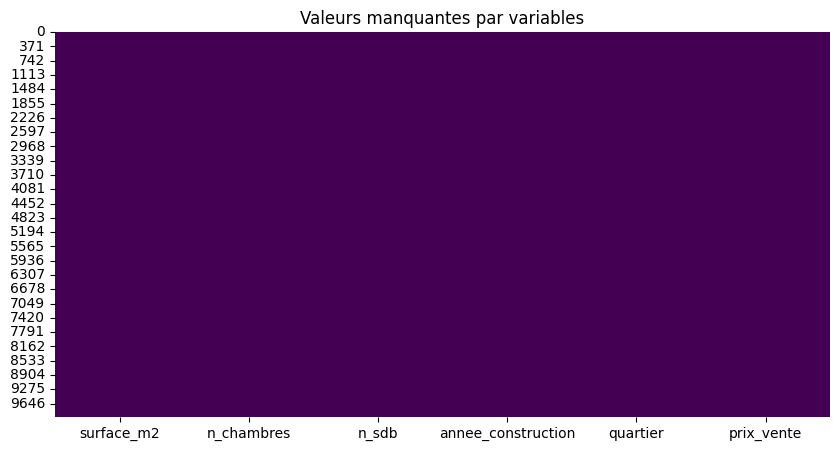

In [45]:
#Affichage des valeurs manquantes

print("Resumé des valeurs manquantes")
print(df_knn.isnull().sum())

#heatmap des valeurs manaquantes 
plt.figure(figsize=(10,5))
sns.heatmap(df_knn.isnull(), cbar=False, cmap="viridis")
plt.title("Valeurs manquantes par variables")
plt.show()

In [47]:
#supprimer les valeurs manquantes 
df_dropna = df.copy() 

df_dropna[df_dropna.isnull().any(axis=1)]


,surface_m2,n_chambres,n_sdb,annee_construction,quartier,prix_vente
3,NaN,4.0,3.0,1999.0,E,301411.15
14,NaN,1.0,1.0,NaN,E,91104.38
29,NaN,NaN,NaN,NaN,B,328111.17
31,NaN,NaN,NaN,NaN,B,413800.73
33,NaN,NaN,NaN,NaN,E,197151.65
...,...,...,...,...,...,...
9783,NaN,NaN,4.0,NaN,A,331036.13
9896,NaN,NaN,NaN,NaN,NaN,261918.47
9909,NaN,1.0,5.0,1986.0,C,294957.46
9920,NaN,NaN,NaN,NaN,NaN,175624.54


In [53]:
# Copier le DataFrame
df_dropna = df.copy()

# Afficher les lignes contenant des valeurs manquantes (facultatif, juste pour info)
print("Lignes contenant des NaN :")
print(df_dropna[df_dropna.isnull().any(axis=1)])

# Nombre initial de lignes
n_before = df_dropna.shape[0]

# Supprimer les lignes avec au moins une valeur manquante
df_dropna = df_dropna.dropna()

# Nombre de lignes après suppression
n_after = df_dropna.shape[0]

# Calcul du ratio de suppression (arrondi à 2 chiffres après la virgule)
ratio_suppression = (n_before - n_after) / n_before

# Affichage des résultats
print(f"Lignes initiales           : {n_before}")
print(f"Lignes après suppression   : {n_after}")
print(f"Ratio de suppression       : {ratio_suppression:.2%}")

if ratio_suppression < 0.05 :
    print("Suppression faible (<5%) : généralement acceptable")
elif ratio_suppression < 0.2 :
    print("Suppression modéréee (5-20%) : Utiliser avec prudence, verifier l'impact sur les données.")
else :
    print("Suppression importante (>20%) : Deconseiller, préférer l'imputation.")


Lignes contenant des NaN :
      surface_m2  n_chambres  n_sdb  annee_construction quartier  prix_vente
3            NaN         4.0    3.0              1999.0        E   301411.15
14           NaN         1.0    1.0                 NaN        E    91104.38
29           NaN         NaN    NaN                 NaN        B   328111.17
31           NaN         NaN    NaN                 NaN        B   413800.73
33           NaN         NaN    NaN                 NaN        E   197151.65
...          ...         ...    ...                 ...      ...         ...
9783         NaN         NaN    4.0                 NaN        A   331036.13
9896         NaN         NaN    NaN                 NaN      NaN   261918.47
9909         NaN         1.0    5.0              1986.0        C   294957.46
9920         NaN         NaN    NaN                 NaN      NaN   175624.54
9930         NaN         NaN    NaN                 NaN      NaN   208910.38

[500 rows x 6 columns]
Lignes initiales         

In [54]:
#supprimer les lignes avec au moins une valeur manquante
df_dropna = df_dropna.dropna()

print(f"Nombre de lignes après suppression : {df_dropna.shape[0]}")

Nombre de lignes après suppression : 9500


Resumé des valeurs manquantes
surface_m2            0
n_chambres            0
n_sdb                 0
annee_construction    0
quartier              0
prix_vente            0
dtype: int64


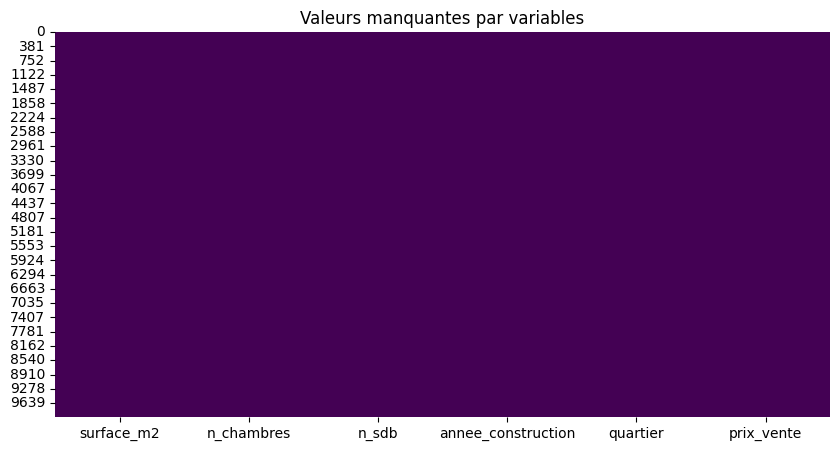

In [55]:
#Affichage des valeurs manquantes

print("Resumé des valeurs manquantes")
print(df_knn.isnull().sum())

#heatmap des valeurs manaquantes 
plt.figure(figsize=(10,5))
sns.heatmap(df_dropna.isnull(), cbar=False, cmap="viridis")
plt.title("Valeurs manquantes par variables")
plt.show()

# IMPUTATION PAR REGRESSION 

In [57]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

df_reg = df.copy()

In [68]:
# Encodage temporaire de la variable catégorielle
df_reg['quartier'] = df_reg['quartier'].astype('category').cat.codes

# Application de l'imputation par régression
iter_imputer = IterativeImputer(random_state=0, max_iter=10)
df_reg[num_cols + ['quartier']] = iter_imputer.fit_transform(df_reg[num_cols + ['quartier']])

# Compléter l'imputation de 'quartier' par le mode
mode_quartier = df_reg['quartier'].mode()[0]
df_reg['quartier'] = df_reg['quartier'].fillna(mode_quartier)

In [69]:
# Vérification
print("Résumé des valeurs manquantes après imputation par régression :")
print(df_reg.isnull().sum())

Résumé des valeurs manquantes après imputation par régression :
surface_m2            0
n_chambres            0
n_sdb                 0
annee_construction    0
quartier              0
prix_vente            0
dtype: int64


Résumé des valeurs manquantes
surface_m2            0
n_chambres            0
n_sdb                 0
annee_construction    0
quartier              0
prix_vente            0
dtype: int64


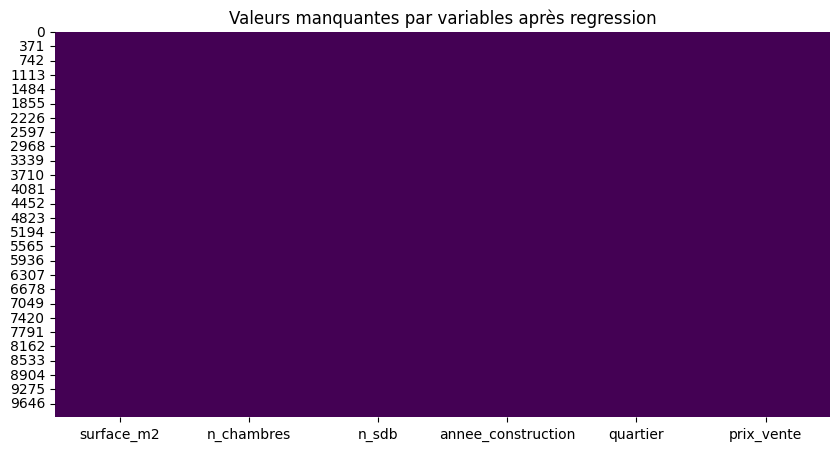

In [121]:
Affichage_graphe(df_reg,"regression")

# IMPUTATION MULTIPLE 

In [97]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Encodage temporaire de la variable catégorielle
df_multi = df.copy()

# df_multi['quartier'] = df_multi['quartier'].astype('category').cat.codes

In [98]:
df_multi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   surface_m2          9500 non-null   float64
 1   n_chambres          9700 non-null   float64
 2   n_sdb               9800 non-null   float64
 3   annee_construction  9600 non-null   float64
 4   quartier            9900 non-null   object 
 5   prix_vente          10000 non-null  float64
dtypes: float64(5), object(1)
memory usage: 468.9+ KB


In [102]:
df_interp = df.copy()

In [103]:
df_interp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   surface_m2          9500 non-null   float64
 1   n_chambres          9700 non-null   float64
 2   n_sdb               9800 non-null   float64
 3   annee_construction  9600 non-null   float64
 4   quartier            9900 non-null   object 
 5   prix_vente          10000 non-null  float64
dtypes: float64(5), object(1)
memory usage: 468.9+ KB


In [104]:
df_interp[num_cols] = df_interp[num_cols].interpolate(method='linear', limit_direction='both')

# Pour la variable catégorielle, compléter par le mode si besoin
for col in cat_cols:
    df_interp[col] = df_interp[col].fillna(df_interp[col].mode()[0])

Resumé des valeurs manquantes par interpolation linéaire
surface_m2            0
n_chambres            0
n_sdb                 0
annee_construction    0
quartier              0
prix_vente            0
dtype: int64


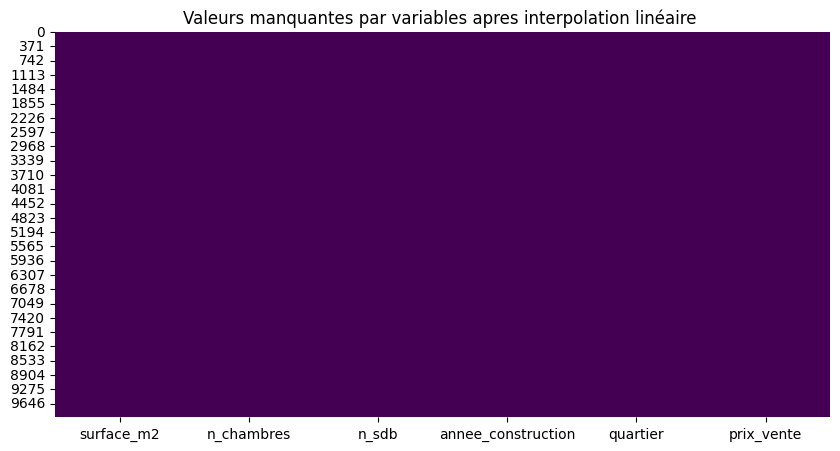

In [105]:
# Vérification graphique et textuelle
Affichage_graphe(df_interp, "interpolation linéaire")

# MICE IMPUTATION

In [106]:
from statsmodels.imputation.mice import MICEData

df_mice = df.copy()

In [107]:
df_mice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   surface_m2          9500 non-null   float64
 1   n_chambres          9700 non-null   float64
 2   n_sdb               9800 non-null   float64
 3   annee_construction  9600 non-null   float64
 4   quartier            9900 non-null   object 
 5   prix_vente          10000 non-null  float64
dtypes: float64(5), object(1)
memory usage: 468.9+ KB


In [110]:
df_mice['quartier'] = df_mice['quartier'].astype('category').cat.codes


# Application de MICE
mice_data = MICEData(df_mice)



# Effectuer plusieurs itérations d’imputation
for _ in range(10):  # 10 cycles d’imputation
    mice_data.update_all()

# Récupérer le DataFrame imputé
df_mice_imputed = mice_data.data


Résumé des valeurs manquantes
surface_m2            0
n_chambres            0
n_sdb                 0
annee_construction    0
quartier              0
prix_vente            0
dtype: int64


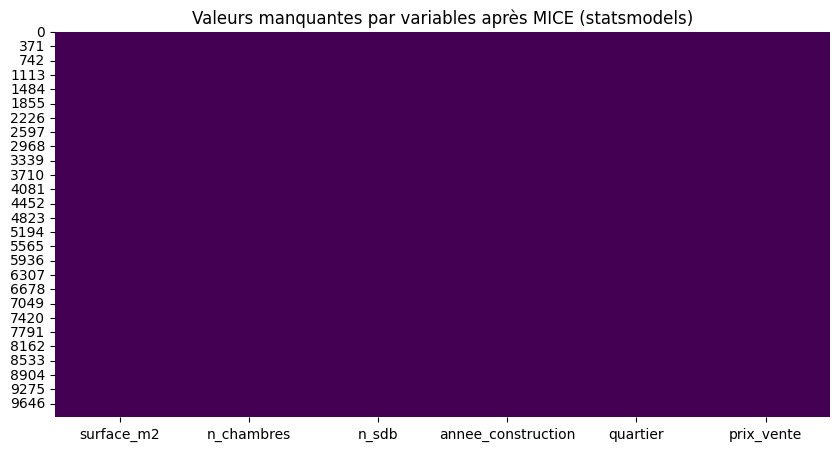

In [112]:

Affichage_graphe(df_mice_imputed, "MICE (statsmodels)")


In [116]:
# Imports nécessaires

from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

try:
    from xgboost import XGBRegressor
    xgb_available = True
except ImportError:
    xgb_available = False

In [117]:
# Préparation des données

# Encodage de la variable catégorielle (quartier) si ce n'est pas déjà fait
df_model = df_mice_imputed.copy()
if df_model['quartier'].dtype == 'object':
    df_model['quartier'] = df_model['quartier'].astype('category').cat.codes

X = df_model.drop('prix_vente', axis=1)
y = df_model['prix_vente']

# Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [118]:
# Définition des modèles
models = {
    "SVR": SVR(),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "KNeighbors": KNeighborsRegressor(),
    "DecisionTree": DecisionTreeRegressor(random_state=42)
}

if xgb_available:
    models["XGBoost"] = XGBRegressor(random_state=42, verbosity=0)


In [119]:
# FONCTION D'EVALUATION

def eval_regression(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"--- {model_name} ---")
    print(f"MAE :  {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R² :   {r2:.3f}")

    # Distribution des résidus
    residuals = y_true - y_pred
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(residuals, kde=True, bins=30, color='orange')
    plt.title(f"Distribution des résidus ({model_name})")
    plt.xlabel("Résidu")
    plt.ylabel("Fréquence")
    
    # Scatterplot y_test vs y_pred
    plt.subplot(1,2,2)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.title(f"y_test vs y_pred ({model_name})")
    plt.xlabel("y_test (réel)")
    plt.ylabel("y_pred (prédit)")
    plt.tight_layout()
    plt.show()
    
    return {"MAE": mae, "RMSE": rmse, "R2": r2}


--- SVR ---
MAE :  49142.46
RMSE : 61977.19
R² :   0.000


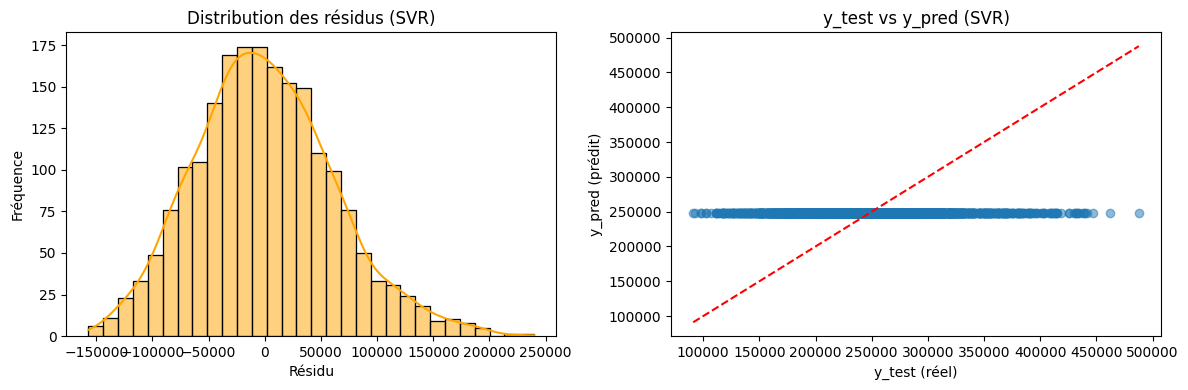

--- GradientBoosting ---
MAE :  16626.56
RMSE : 21012.14
R² :   0.885


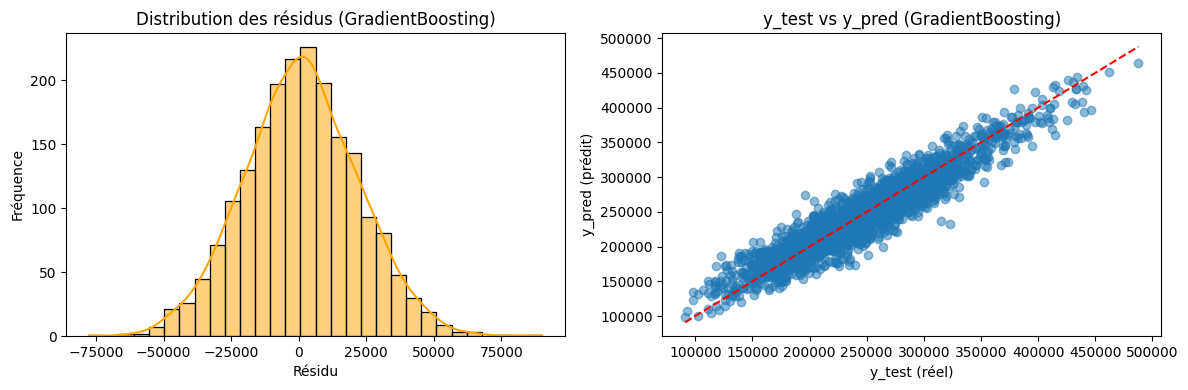

--- KNeighbors ---
MAE :  23605.39
RMSE : 29736.92
R² :   0.770


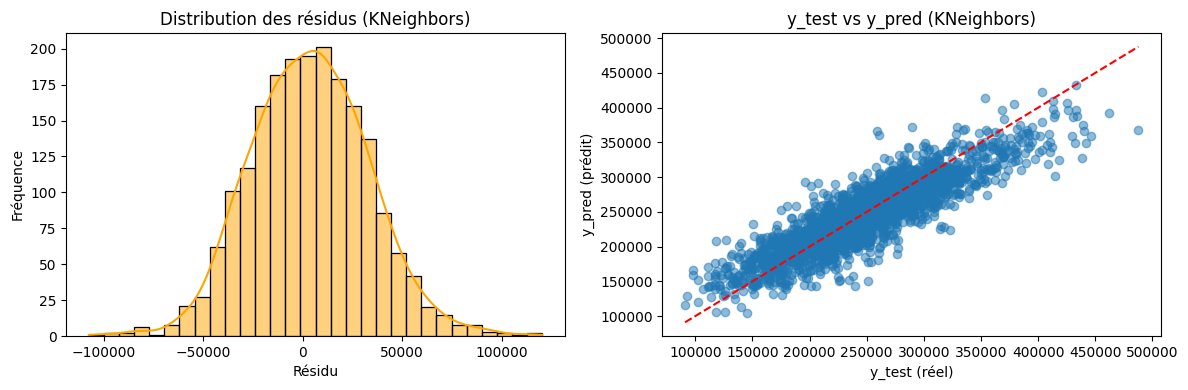

--- DecisionTree ---
MAE :  24608.57
RMSE : 30636.52
R² :   0.756


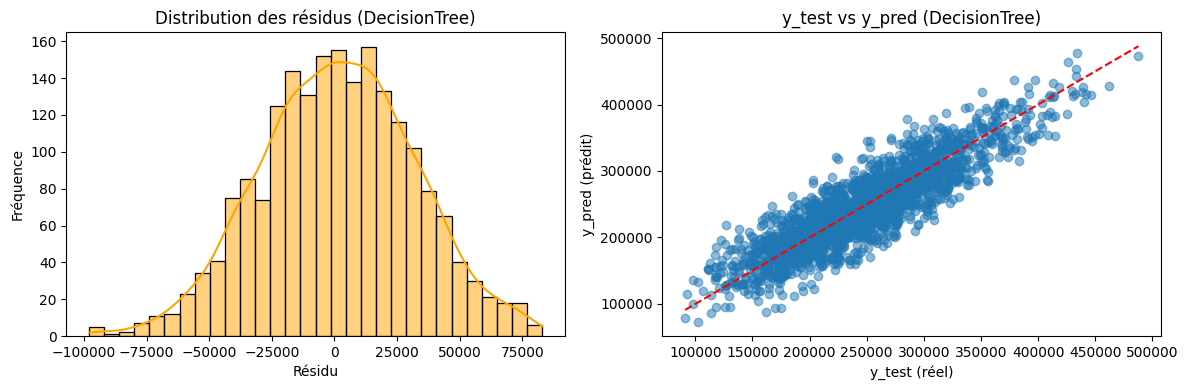

--- XGBoost ---
MAE :  17859.45
RMSE : 22447.76
R² :   0.869


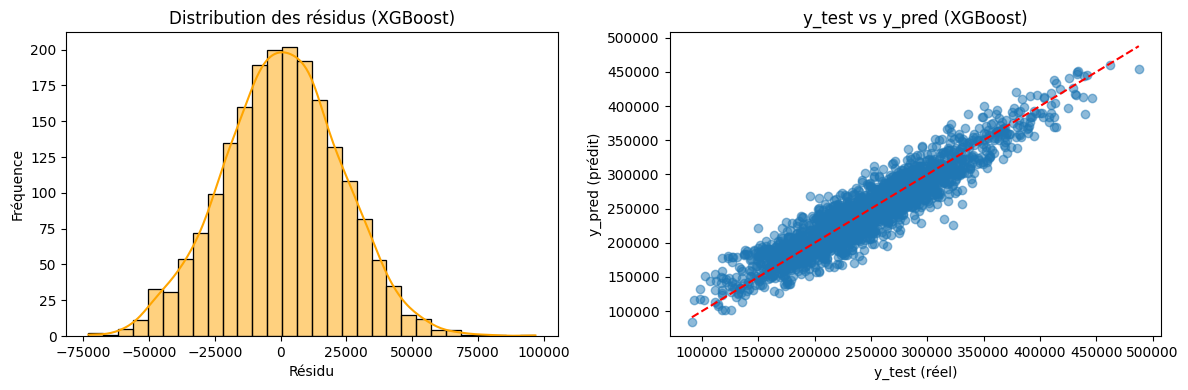

In [120]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = eval_regression(y_test, y_pred, name)


In [ ]:
df